In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import hvplot.pandas


In [2]:
# Suppressing warnings
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [3]:
#Getting BTC Dataframe

# Define the ticker symbol for Bitcoin
btc_symbol = "BTC-USD"

# Specify the date range for the past 10 years
start_date = "2013-10-09"
end_date = "2023-12-04"

# Use yfinance to get Bitcoin data for the specified date range
btc_data = yf.download(btc_symbol, start=start_date, end=end_date, progress=False)

# Extract the "Close" column and create a DataFrame
btc_df = btc_data[["Close"]]

# Print the first few rows of the DataFrame
print(btc_df.head())
print(btc_df.tail())

                 Close
Date                  
2014-09-17  457.334015
2014-09-18  424.440002
2014-09-19  394.795990
2014-09-20  408.903992
2014-09-21  398.821014
                   Close
Date                    
2023-11-29  37858.492188
2023-11-30  37712.746094
2023-12-01  38688.750000
2023-12-02  39476.332031
2023-12-03  39978.390625


In [6]:
# Plot the closing prices for Bitcoin
btc_df.hvplot.line(
    title="Bitcoin Closing Prices",
    xlabel="Date",
    ylabel="Closing Price ($)",
    width=1000,
    height=400,
)



:Curve   [Date]   (Close)

In [26]:
# Preprocessing Data
bitcoin_data = btc_df.copy()
bitcoin_data = bitcoin_data.dropna()
bitcoin_data.head()

,Close
Date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014


In [27]:
# Normalizing BTC Data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(btc_df["Close"].values.reshape(-1, 1))

In [29]:
# Prepare the data for LSTM
def create_dataset(data, time_step):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i : (i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 100
X, y = create_dataset(scaled_data, time_step)

In [30]:
# Reshape the data
X = X.reshape((X.shape[0], X.shape[1], 1))

In [31]:
# Spit the data into training and testing
train_size = int(len(y) * 0.80)
test_size = len(scaled_data) - train_size
train_data, test_data = X[0:train_size, :], X[train_size : len(scaled_data), :]

In [33]:
# Reshape into X_train and y_train
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)




In [35]:
# Building the LSTM Model
model = Sequential()
model.add(LSTM(units=30, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=30))
model.add(Dense(1))

# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")
model.fit(X_train, y_train, epochs=10, batch_size=32)


# Summarize the model
model.summary()

Epoch 1/10
79/79 [==============================] - 3s 19ms/step - loss: 0.0088
Epoch 2/10
79/79 [==============================] - 2s 19ms/step - loss: 9.0202e-04
Epoch 3/10
79/79 [==============================] - 1s 19ms/step - loss: 8.3709e-04
Epoch 4/10
79/79 [==============================] - 1s 19ms/step - loss: 6.8045e-04
Epoch 5/10
79/79 [==============================] - 1s 19ms/step - loss: 6.5115e-04
Epoch 6/10
79/79 [==============================] - 1s 19ms/step - loss: 6.7963e-04
Epoch 7/10
79/79 [==============================] - 2s 20ms/step - loss: 6.4964e-04
Epoch 8/10
79/79 [==============================] - 2s 20ms/step - loss: 5.2324e-04
Epoch 9/10
79/79 [==============================] - 1s 19ms/step - loss: 5.6159e-04
Epoch 10/10
79/79 [==============================] - 1s 19ms/step - loss: 5.3023e-04
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 

In [36]:
# Predicting BTC Prices
predicted = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted)

18/18 [==============================] - 0s 6ms/step


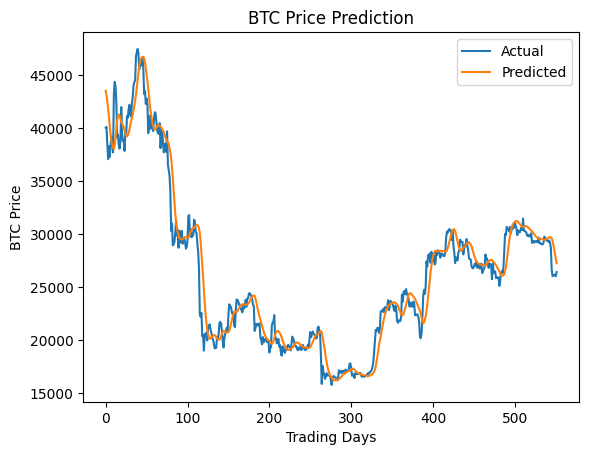

In [39]:
# Visualize the predicted prices
plt.plot(scaler.inverse_transform(y_test.reshape(-1, 1)))
plt.plot(predicted_prices)
plt.title("BTC Price Prediction")
plt.xlabel("Trading Days")
plt.ylabel("BTC Price")
plt.legend(["Actual", "Predicted"])
plt.show()
